# Loss landcape of a linear regression model

We'll assume $\beta = 0$ to be able visualize the loss as a function of the slope $\alpha$ and error term $\sigma$.

$y \sim \mathcal{N}(\alpha x, \sigma)$

## Setting up the environment

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

In [3]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

In [4]:
seed = 444
np.random.seed(seed);
torch.manual_seed(seed);

## Normal distribution

If $z$ is drawn from a normal distribution with mean $\mu$ and standard deviation $\sigma$, then the probability of $z$ follows the relationship:

$z \sim \mathcal{N}(\mu, \sigma) \iff P(z \mid \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{z - \mu}{\sigma})^2}$

$P(z \mid \mu, \sigma)$ is the probability density function (PDF) of the normal distribution.

In [35]:
def plot_normal_distributions():
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    normal_fn = lambda z, m, s: (1/(s * np.sqrt(2*np.pi))) * np.exp(-0.5*((z - m) / s)**2)
    
    x = np.linspace(-7.5, 10, 300)
    
    ax.plot(x, normal_fn(x, 0, 1), label=r'$\mu = 0$, $\sigma = 1$', color=palette[0])
    ax.plot(x, normal_fn(x, 0, 2), label=r'$\mu = 0$, $\sigma = 2$', color=palette[1])
    ax.plot(x, normal_fn(x, 5, 0.9), label=r'$\mu = 5$, $\sigma = .9$', color=palette[2])
    
    ax.set_xlabel('$z$');
    ax.set_ylabel(r'$P(z \mid \mu, \sigma)$');
    ax.set_title('Probability density function (PDF) of the normal distribution');
    ax.legend(loc='upper left');
    
    return f, ax

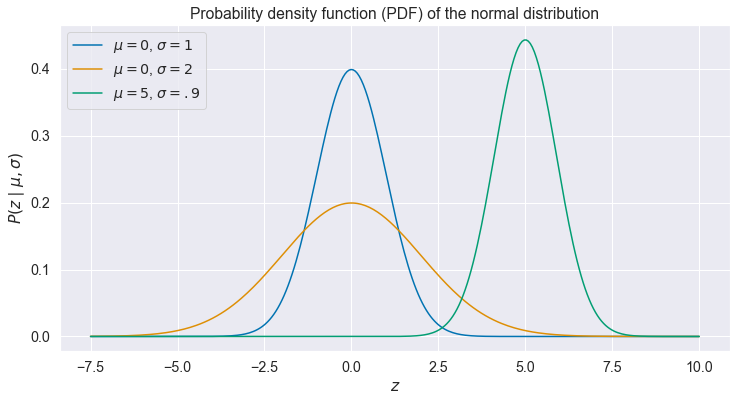

In [36]:
f, _ = plot_normal_distributions()

In [37]:
#f.savefig(
#    '/Users/srom/workspace/romainstrock.com/assets/img/uncertainty/normal.png', 
#    bbox_inches='tight', 
#    dpi=120,
#)

## Softplus

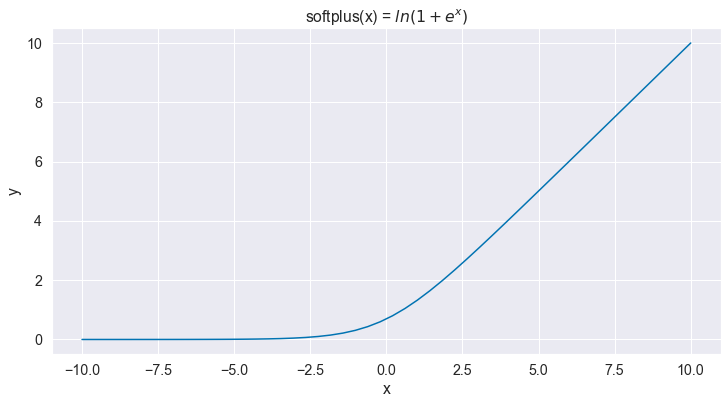

In [10]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
x_r = np.linspace(-10, 10)
y_r = np.log(1 + np.exp(x_r))
ax.plot(x_r, y_r);
ax.set_xlabel('x');
ax.set_ylabel('y')
ax.set_title('softplus(x) = $ln(1 + e^x)$');

In [11]:
#f.savefig(
#    '/Users/srom/workspace/romainstrock.com/assets/img/uncertainty/softplus.png', 
#    bbox_inches='tight', 
#    dpi=120,
#)

## Generate dataset

In [7]:
def generate_samples(α, β, σ, min_x=-1, max_x=1, n_samples=500):
    x = np.linspace(min_x, max_x, n_samples)[:, np.newaxis]
    y = α * x + β
    dist = torch.distributions.Normal(torch.from_numpy(y), σ)
    y_sample = dist.sample().detach().numpy()
    return x, y, y_sample

In [8]:
def plot_line(x, y, y_sample):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(x.flatten(), y.flatten(), '-', color=palette[0], linewidth=3)
    ax.scatter(x.flatten(), y_sample.flatten(), color=palette[0], alpha=0.8)
    ax.set_xlabel('input x')
    ax.set_ylabel('output y')
    return ax

In [9]:
α_actual = 2.6
β_actual = 0.0
σ_actual = 0.7

x, y, y_sample = generate_samples(α_actual, β_actual, σ_actual)

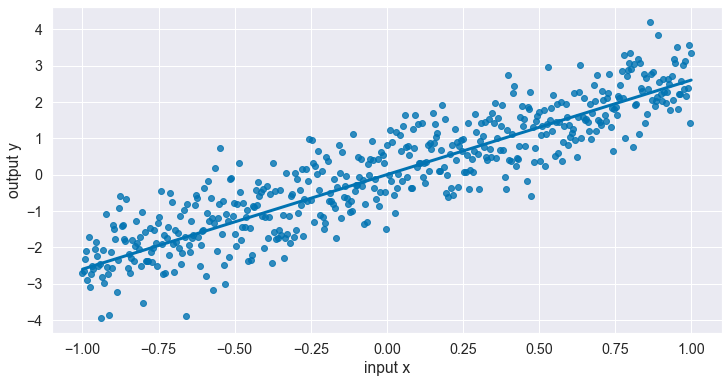

In [10]:
plot_line(x, y, y_sample);

## Model

In [11]:
initial_α = 1.8
initial_s = 1.5

In [12]:
class LinearNormal(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.α = torch.nn.Parameter(torch.tensor(initial_α))
        self.s = torch.nn.Parameter(torch.tensor(initial_s))
        
    @property
    def sigma(self):
        return F.softplus(self.s)  # ensure σ > 0
        
    def forward(self, x):
        m = self.α * x
        σ = self.sigma
        return torch.distributions.Normal(m, σ)

In [13]:
def compute_loss(model, x, y):
    out_dist = model(x)
    neg_log_likelihood = -out_dist.log_prob(y)
    return torch.mean(neg_log_likelihood)


def predict(model, x):
    model.eval()
    out_dist = model(x)
    return out_dist.mean, out_dist.stddev, out_dist

In [14]:
def plot_results(x, y, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(x.flatten(), y.flatten(), '-', color=palette[0], linewidth=2, label='Actual line')
    ax.plot(x.flatten(), y_pred.flatten(), '-', color=palette[1], linewidth=2, label='Predicted line')
    ax.set_xlabel('input x')
    ax.set_ylabel('output y')
    ax.legend()
    return ax

In [15]:
model = LinearNormal()

In [16]:
y_pred, _, y_dist = predict(model, torch.from_numpy(x))
y_pred_sample = y_dist.sample()

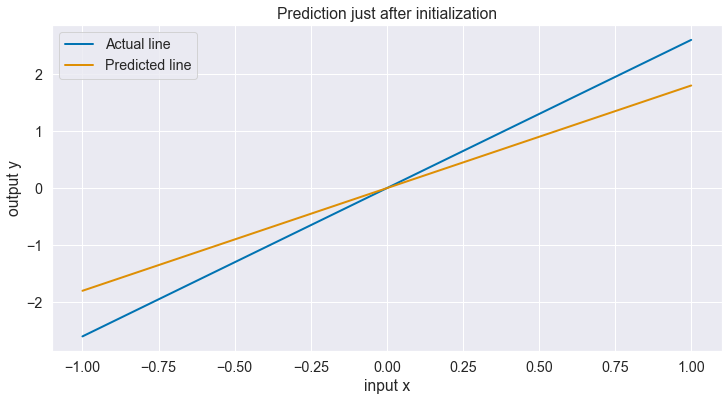

In [17]:
ax = plot_results(
    x.flatten(), 
    α_actual * x.flatten(), 
    y_pred.detach().numpy(), 
)
ax.set_title('Prediction just after initialization');

In [18]:
def compute_train_test_split(x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    return (
        torch.from_numpy(x_train),
        torch.from_numpy(x_test),
        torch.from_numpy(y_train),
        torch.from_numpy(y_test),
    )

In [19]:
x_train, x_test, y_train, y_test = compute_train_test_split(x, y_sample, test_size=0.2)

## Loss function

The **probability density function** (PDF) of the normal distribution $\mathcal{N}(\mu, \sigma)$, also called **likelihood function**, is defined as:

$P(z \mid \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{z - \mu}{\sigma})^2}$

It is customary to consider the logarithm of the likelihood function for numerical stability reason. It is also typical in machine learning to minimize rather than maximize functions, so we'll consider **the negative log likelihood**:

$-\ln{P(z \mid \mu, \sigma)} = \ln{(\sigma\sqrt{2\pi})} + \frac{1}{2\sigma^2}(z - \mu)^2$

In the context of linear regression, we have $\mu = \alpha x + \beta$ and we want to minimize the sum of the negative log likelihood function evaluated for all points $(x, y)$ in our dataset of observations $\mathcal{D} \subset \mathbb{R}^2$.

$\text{Loss}\,(\alpha, \beta, \sigma, \mathcal{D}) = \sum\limits_{(x, y) \in \mathcal{D}} -\ln{P(y \mid \alpha x + \beta, \sigma)} = \sum\limits_{(x, y) \in \mathcal{D}} \ln{(\sigma\sqrt{2\pi})} + \frac{1}{2\sigma^2}\{y - (\alpha x + \beta)\}^2$

In [20]:
def loss_fn(x, y, alpha, sigma):
    m = torch.from_numpy(alpha * x)
    σ = torch.from_numpy(sigma)
    observations = torch.from_numpy(y)
    
    dist = torch.distributions.Normal(m, σ)
    neg_log_likelihood = -dist.log_prob(observations)
    
    return float(torch.mean(neg_log_likelihood).detach().numpy())

def fitness_fn(x, y, alpha, sigma):
    output = np.zeros((len(alpha),))
    for i in range(len(alpha)):
        output[i] = loss_fn(x, y, alpha[i], sigma[i])
    return output

# Create a grid of 300 by 300 = 90,000 input points
a = np.linspace(1.5, 3.5, 300)
b = np.log(1 + np.exp(np.linspace(-1.0, 2.0, 300)))
A, B = np.meshgrid(a, b)
X_grid = np.array([[u, v] for u, v in zip(np.ravel(A), np.ravel(B))])

# Sample outputs based on grid points
alpha = X_grid[:,:1]
s = X_grid[:,1:]
zs = fitness_fn(x, y_sample, alpha, s)
Z = zs.reshape(A.shape)

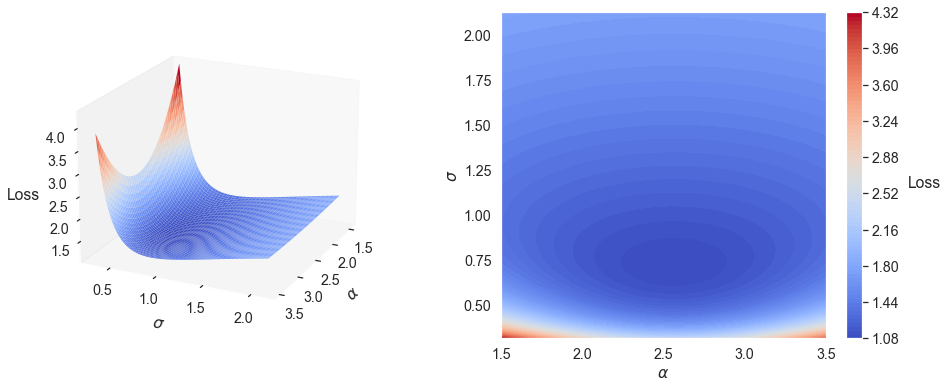

In [21]:
fig = plt.figure(figsize=(16, 6))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0], projection='3d')
ax2 = fig.add_subplot(gs[0,1])

# Plot surface
ax1.plot_surface(A, B, Z, cmap='coolwarm', linewidth=0)

# Plot filled contours
cs = ax2.contourf(A, B, Z, cmap='coolwarm', levels=80)

# Colour map
cbar = plt.colorbar(cs, ax=ax2)
cbar.ax.set_ylabel('Loss', rotation=360)
cbar.ax.get_yaxis().labelpad = 25

# Surface labels
ax1.get_xaxis().labelpad = 10
ax1.get_yaxis().labelpad = 10
ax1.get_zaxis().labelpad = 10
ax1.set_xlabel(r'$\alpha$');
ax1.set_ylabel(r'$\sigma$');
ax1.set_zlabel('Loss');
ax1.grid(False);
ax1.view_init(20, 25);
ax1.set_facecolor('white');

# Contour labels
ax2.set_xlabel(r'$\alpha$');
ax2.set_ylabel(r'$\sigma$');
ax2.grid(False);

## Visualizing gradient descent

In [22]:
def train_one_step(model, optimizer, x_batch, y_batch):
    model.train()
    optimizer.zero_grad()
    loss = compute_loss(model, x_batch, y_batch)
    loss.backward()
    optimizer.step()
    return loss

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)

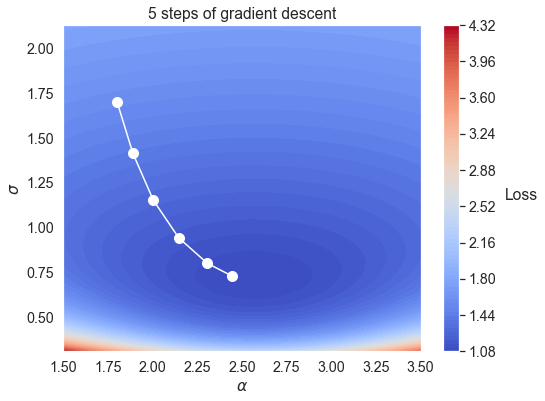

In [24]:
fig = plt.figure(figsize=(8, 6))
gs = mpl.gridspec.GridSpec(1, 1, figure=fig)
ax2 = fig.add_subplot(gs[0,0])

# Plot filled contours
cs = ax2.contourf(A, B, Z, cmap='coolwarm', levels=80)

# Colour map
cbar = plt.colorbar(cs, ax=ax2)
cbar.ax.set_ylabel('Loss', rotation=360)
cbar.ax.get_yaxis().labelpad = 25

# Contour labels
ax2.set_xlabel(r'$\alpha$');
ax2.set_ylabel(r'$\sigma$');
ax2.grid(False);

fn = lambda x: np.log(1 + np.exp(x))

# Initial value
xx = [initial_α]
yy = [fn(initial_s)]

# gradient steps
for _ in range(5):
    loss = train_one_step(model, optimizer, x_train, y_train)
    
    xx.append(float(model.α.detach().numpy()))
    yy.append(fn(float(model.s.detach().numpy())))

ax2.plot(xx, yy, 'o-', color='white', markersize=10);
ax2.set_title('5 steps of gradient descent');